<a href="https://colab.research.google.com/github/hebatoallah-yehya1111/Head-pose-estimator-final/blob/main/Head-pose-estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Required Libraries

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score,GridSearchCV





### Dowlining Data

In [3]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [4]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [5]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img


### Preparing Data

In [6]:
# X_points, Y_points, labels and detected files which are the images thar MediaPipe was able to detect the face  
X_points = []
Y_points = []
labels = []
detected_files = []

# extracting the file names (2000 name)
file_names = sorted([Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")])

# detecting faces and extracting the points
faceModule = mediapipe.solutions.face_mesh
# looping over the file names to load the images and their corresponding mat file
for filename in file_names:
  with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+filename+'.jpg')
    # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
          # appending the file names where have been detected.
          detected_files.append(filename)
          # detecting the face
          face = results.multi_face_landmarks[0]
          # initializing two lists to store the points for the image.
          X = []
          Y = []
          # looping over the 468 points of x and y
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image.
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # X_features
              X.append(relative_x)
              # Y_features
              Y.append(relative_y)

          # converting the lists to numpy arrays
          X = np.array(X)
          Y = np.array(Y)
          # appending the points of the images in the list of all image points
          X_points.append(X)
          Y_points.append(Y)

          # loading the mat file to extract the labels (pitch,yaw,roll)
          mat_file = sio.loadmat('/content/AFLW2000/'+filename+'.mat')
          # extracting the labels 3 angels
          pose_para = mat_file["Pose_Para"][0][:3]
          # appending the 3 angels to labels list
          labels.append(pose_para)

# converting features and labels to 2D array
X_points = np.array(X_points)
Y_points = np.array(Y_points)
labels = np.array(labels)

pitch_label,  yaw_label,roll_label =labels[:, 0], labels[:, 1], labels[:, 2]


print(X_points.shape)
print(Y_points.shape)
print(labels.shape)
print(roll_label.shape)
print(pitch_label.shape)
print(yaw_label.shape)




(1853, 468)
(1853, 468)
(1853, 3)
(1853,)
(1853,)
(1853,)


### Normalizing Data 

In [7]:

# centering the data arround the 99th point 
preFeatures= np.hstack([X_points,Y_points])
preFeatures=np.array(preFeatures)
#print(preFeatures.shape)
Center_preFeatures = preFeatures -preFeatures[:,99].reshape(-1,1)

# normalizing the data to be in the same scale by dividing over the distance between point 10 and point 171
preFeatures_200 =preFeatures[:,171]
print(preFeatures_200.shape)
preFeatures_20 = preFeatures[:,10]

# computing the distance
distance = np.linalg.norm(np.array((preFeatures_20) - np.array((preFeatures_200)))).reshape(-1,1)
features= Center_preFeatures / distance


print(features)
print(features.shape)

(1853,)
[[ 0.00452516  0.00543019  0.00543019 ...  0.00769277  0.00181006
   0.        ]
 [ 0.         -0.00497768  0.00135755 ...  0.01493303  0.01221794
   0.01086039]
 [ 0.0027151   0.00316761  0.0027151  ...  0.08507303  0.08281045
   0.08235793]
 ...
 [ 0.0027151   0.00633523  0.00452516 ... -0.00633523 -0.00497768
  -0.00633523]
 [ 0.00452516  0.00633523  0.00543019 ...  0.00678774  0.00226258
   0.00090503]
 [ 0.00588271  0.00543019  0.00497768 ...  0.00181006 -0.00135755
  -0.00316761]]
(1853, 936)


### Spliting Data into Test and Train datasets

In [8]:
X_train,X_test,y_train,y_test ,file_train,file_test = train_test_split(features,labels,detected_files,test_size = 0.2,random_state = 20)
y_train_pitch , y_train_yaw , y_train_roll= y_train[:,0],y_train[:,1],y_train[:,2]
y_test_pitch , y_test_yaw , y_test_roll= y_test[:,0],y_test[:,1],y_test[:,2]


### **XGBoost Regressor with pitch**




In [9]:
xgbr_pitch = xgb.XGBRegressor(learning_rate=0.89, max_depth=1, n_estimators=10,verbosity=0,random_state=42)
print(xgbr_pitch)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


xgbr_pitch.fit(X_train, y_train_pitch)
mse_train = mean_squared_error(xgbr_pitch.predict(X_train),y_train_pitch)
print(f'MSE on Traing Data: {mse_train}')
ypred_pitch = xgbr_pitch.predict(X_test)
mse_test = mean_squared_error(y_test_pitch, ypred_pitch)
pitch_crossval=cross_val_score(xgbr_pitch,features,pitch_label,scoring="neg_mean_absolute_error")
print(f'Cross Val Average Score : {pitch_crossval.mean()}')
print(f'MSE on Testing Data: {mse_test}')







XGBRegressor(learning_rate=0.89, max_depth=1, n_estimators=10, random_state=42,
             verbosity=0)
MSE on Traing Data: 0.15614426432511727
Cross Val Average Score : -0.19355274740437056
MSE on Testing Data: 0.19568398391692987


### **XGBoost Regressor with yaw**

In [10]:
xgbr_yaw = xgb.XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=7,verbosity=0,random_state=42)
print(xgbr_yaw)
from sklearn.metrics import mean_squared_error


xgbr_yaw.fit(X_train, y_train_yaw)
mse_train = mean_squared_error(xgbr_yaw.predict(X_train),y_train_yaw)
print(f'MSE on Traing Data: {mse_train}')
ypred_yaw = xgbr_yaw.predict(X_test)
mse_test = mean_squared_error(y_test_yaw, ypred_yaw)
yaw_crossval=cross_val_score(xgbr_yaw,features,yaw_label,scoring="neg_mean_absolute_error")
print(f'Cross Val Average Score : {yaw_crossval.mean()}')
print(f'MSE on Testing Data: {mse_test}')

XGBRegressor(learning_rate=0.5, max_depth=5, n_estimators=7, random_state=42,
             verbosity=0)
MSE on Traing Data: 0.005490756642561162
Cross Val Average Score : -0.09045514542882076
MSE on Testing Data: 0.10351139614458006


### **XGBoost Regressor with roll**

In [15]:
xgbr_roll = xgb.XGBRegressor(learning_rate=0.2, max_depth=5, n_estimators=7,verbosity=0,random_state=42)
print(xgbr_roll)

xgbr_roll.fit(X_train,  y_train_roll)
mse_train = mean_squared_error(xgbr_roll.predict(X_train),y_train_roll)
print(f'MSE on Traing Data: {mse_train}')
ypred_roll = xgbr_roll.predict(X_test)
mse_test = mean_squared_error(y_test_roll, ypred_roll)
roll_crossval=cross_val_score(xgbr_roll,features,roll_label,scoring="neg_mean_absolute_error")
print(f'Cross Val Average Score : {roll_crossval.mean()}')
print(f'MSE on Testing Data: {mse_test}')

XGBRegressor(learning_rate=0.2, max_depth=5, n_estimators=7, random_state=42,
             verbosity=0)
MSE on Traing Data: 0.08273274883989688
Cross Val Average Score : -0.18098841012509398
MSE on Testing Data: 0.29743750321473983


In [16]:
svr_roll = SVR(C=10)
print(svr_roll)

svr_roll.fit(X_train, y_train_roll)
mse_train = mean_squared_error(svr_roll.predict(X_train),y_train_roll)
print(f'MSE on Traing Data: {mse_train}')
ypred_roll = svr_roll.predict(X_test)
mse_test = mean_squared_error(y_test_roll, ypred_roll)
roll_crossval=cross_val_score(svr_roll,features,roll_label,scoring="neg_mean_absolute_error")
print(f'Cross Val Average Score : {roll_crossval.mean()}')
print(f'MSE on Testing Data: {mse_test}')


SVR(C=10)
MSE on Traing Data: 0.22266911360124955
Cross Val Average Score : -0.08438050291154099
MSE on Testing Data: 0.10417177850364831


### **Choosing Random image and test the model**

(936,)
(936,)


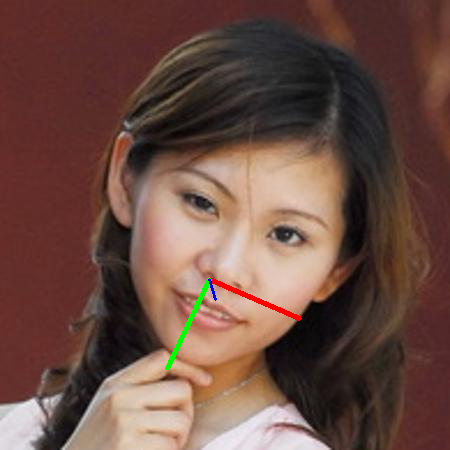

In [37]:
# choosing random image from the testing data
image_name = random.choice(file_test)
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as face:
  # reading the image
  frame = cv2.imread('/content/AFLW2000/' + image_name + '.jpg')
  # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
  results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    for face in results.multi_face_landmarks:
        # initializing two lists to store x and y points
        X = []
        Y = []
        for j,landmark in enumerate(face.landmark):
            x = landmark.x
            y = landmark.y
            # getting the points back to its actual values
            shape = frame.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            # appending the points to the X and Y lists
            X.append(relative_x)
            Y.append(relative_y)

        # converting the x and y points to numpy array
        X = np.array(X)
        Y = np.array(Y)

        # centering the points of x and y values arround the point no. 99
        preFeatures= np.hstack([X,Y])
        print(preFeatures.shape)

        preFeatures=np.array(preFeatures)
        print(preFeatures.shape)
        Center_preFeatures = preFeatures -preFeatures[99].reshape(-1,1)
        # computing the distance between the point 171 and 10
        d = np.linalg.norm(np.array((preFeatures[171])) - np.array((preFeatures[10])))
        # normalizing the points
        Features_norm = Center_preFeatures/d
        # concatinating the x and y points to predict the labels (pitch,yaw,roll)
        points = Features_norm.reshape(1,-1)
        # predicting the 3 angels to draw the axis on the image
        pred_pitch = xgbr_pitch.predict(points)
        pred_yaw = xgbr_yaw.predict(points)
        pred_roll = xgbr_roll.predict(points)
        cv2_imshow(draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[99],Y[99]))
        


### **Creating a class to do Smoothing in the Next Function**

In [38]:
class Queue:
    # defining the constructor
    def __init__(self,max_size):
        self.queue = []
        self.length = 0
        self.max_size = max_size
    
    # adding values to the queue
    def enqueue(self,x):
        if self.length < self.max_size:
          self.queue.append(x)
          self.length = self.length+1
        else:
          print("You have reached the maximum size") 
    # removing values from the queue
    def dequeue(self):
        if len(self.queue) > 0:
            removed = self.queue[0]
            del self.queue[0]
            self.length = self.length-1
            return removed
        else:
            print("Queue is Empty")

    # checking if the queue is full
    def IsFull(self):
      if self.length == self.max_size:
        return True
    
    # printing the queue values
    def print_queue(self):
        for i in self.queue:
            print(i)

### **Test the model on my own video**

In [68]:
# Create a VideoCapture object and read from input file
def Create_TestVideo(pitch_model,yaw_model,roll_model,smoothing = False,size = 30):

  cap = cv2.VideoCapture('WhatsApp Video 2022-06-17 at 6.58.04 PM.mp4')
  width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
      print("Error opening video file")

  
  pitch_queue = Queue(max_size = size)
  yaw_queue = Queue(max_size = size)
  roll_queue = Queue(max_size = size)

  # initializing a list to store the frames   
  img_array = []
  # Read until video is completed
  while(cap.isOpened()):   
    # Capture frame-by-frame
      ret, frame = cap.read()
      if ret == True:
        with faceModule.FaceMesh(static_image_mode=True) as face:
          # processing the image to detect the face and then generating the land marks (468 for each x,y,z).
          results = face.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
          if results.multi_face_landmarks != None:
            for face in results.multi_face_landmarks:
                # initializing X and Y lists to store the spacial coordinates of the points
                X = []
                Y = []
                # looping over the landmarks to extract x and y
                for j,landmark in enumerate(face.landmark):
                    x = landmark.x
                    y = landmark.y
                    # retrieve the true values of x and y
                    shape = frame.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    X.append(relative_x)
                    Y.append(relative_y)

                X = np.array(X)
                Y = np.array(Y)
                preFeatures= np.hstack([X,Y])

                preFeatures=np.array(preFeatures)
                Center_preFeatures = preFeatures -preFeatures[99].reshape(-1,1)
               # computing the distance between the point 171 and 10
                d = np.linalg.norm(np.array((preFeatures[171])) - np.array((preFeatures[10])))
                # normalizing the points
                Features_norm = Center_preFeatures/d
               # concatinating the x and y points to predict the labels (pitch,yaw,roll)
                points = Features_norm.reshape(1,-1)
                # predicting the 3 angels to draw the axis on the image
                pred_pitch = pitch_model.predict(points)
                pred_yaw = yaw_model.predict(points)
                pred_roll = roll_model.predict(points)
                
                if smoothing  == True:
                  if not pitch_queue.IsFull(): 
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)
                  else:
                    pitch_queue.dequeue()
                    yaw_queue.dequeue()
                    roll_queue.dequeue()
                    pitch_queue.enqueue(pred_pitch)
                    yaw_queue.enqueue(pred_yaw)
                    roll_queue.enqueue(pred_roll)

                  pitch = sum(pitch_queue.queue)/len(pitch_queue.queue)
                  yaw = sum(yaw_queue.queue)/len(yaw_queue.queue)
                  roll = sum(roll_queue.queue)/len(roll_queue.queue)
                  draw_axis(frame,pitch,yaw,roll,X[1],Y[1])

                else:
                  draw_axis(frame,pred_pitch,pred_yaw,pred_roll,X[1],Y[1])
                # appending the result frame to the img_array list
                img_array.append(frame)
      # Break the loop
      else: 
          break
  cap.release()  
  # Closes all the frames
  cv2.destroyAllWindows()
  print("Number of Detected Frames = ",len(img_array))
  # converting the frames to video
  out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))
  for i in range(len(img_array)):
    out.write(img_array[i])
  out.release()

In [69]:
Create_TestVideo(xgbr_pitch,xgbr_yaw,xgbr_roll,smoothing = True,size=25)


Number of Detected Frames =  577


### Download the video

In [65]:
from google.colab import files
files.download('out.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>